In [275]:
import numpy as np
from scipy.linalg import svd
import pandas as pd 
import copy

In [327]:
def gappy_POD_basis(data, n_modes):
    """
    Perform Proper Orthogonal Decomposition (POD) to generate basis from CFD data.

    Parameters:
        data (ndarray): CFD data matrix with time snapshots as rows.
        n_modes (int): Number of modes to retain.

    Returns:
        modes (ndarray): POD modes.
    """
    # Perform Singular Value Decomposition (SVD)
    U, S, Vh = svd(data.T, full_matrices=False)

    # Retain only the specified number of modes
    modes = U[:, :n_modes]
    print(U.shape)

    return modes

import numpy as np

def reconstruct_data(experimental_data, basis_modes, mask):
    """
    Reconstruct experimental data using the given basis modes and a masking array.

    Parameters:
        experimental_data (ndarray): Experimental data matrix.
        basis_modes (ndarray): Basis modes obtained from POD.
        mask (ndarray): Masking array indicating the points where we have experimental data.

    Returns:
        reconstructed_data (ndarray): Reconstructed data matrix.
    """
    # Flatten the experimental data and mask
    experimental_data_flat = experimental_data.flatten()
    mask_flat = mask.flatten()

    # Get indices of non-masked data points
    non_masked_indices = np.where(mask_flat)

    # Extract only the non-masked experimental data and corresponding basis modes
    experimental_data_non_masked = experimental_data_flat[non_masked_indices]
    basis_modes_non_masked = basis_modes[non_masked_indices[0], :]

    # Solve the least squares problem
    coefficients, residuals, _, _ = np.linalg.lstsq(basis_modes_non_masked, experimental_data_non_masked, rcond=None)

    # Reconstruct the data using the coefficients
    reconstructed_data_flat = np.dot(basis_modes, coefficients)

    # Reshape the reconstructed data to the original shape
    reconstructed_data = reconstructed_data_flat.reshape(experimental_data.shape)

    return reconstructed_data

In [165]:
# load numerical data
def read_xfoil_file(fname):
    df = pd.read_csv(f"./data/gpod/xfoil/{fname}", skiprows=3, delim_whitespace=True,
                     names=['x', 'y', 'Cp'], index_col=False)
    df["region"] = df['y'].apply(lambda x: "suction" if x > 0.0 else "pressure")
    return df

In [172]:
xfoil_files = os.listdir(os.getcwd()+"/data/gpod/xfoil")
df_lst = [read_xfoil_file(fname) for fname in xfoil_files]
x_xfoil = df_lst[0][df_lst[0].region == "suction"].x

In [185]:
# grab experimental data
df_exp = pd.read_csv("./data/gpod/experimental/Ladson_Re3M_alpha00.txt", skiprows=1,
                     delim_whitespace=True, names=['x', 'Cp']).iloc[22:]

In [186]:
# Turn each snapshot into 1xN, so that we have MxN df where M: data for each time; N: # data points
cp_data = np.array([df[df.region == "suction"]['Cp'].to_numpy() for df in df_lst])

# Testing

In [303]:
# compute modes
modes = gappy_POD_basis(cp_data, 3)

In [304]:
# Interpolated experimental data s.t. 
xsel = x_xfoil.loc[x_xfoil[np.logical_and(x_xfoil > 0.2, x_xfoil < 0.8)][::5].index]
cpsel = np.interp(xsel, df_exp.x, df_exp.Cp)

In [305]:
exp_mask = np.zeros((len(modes), 1))
idx_exp = [np.argwhere(x_xfoil == x)[0][0] for x in xsel]
exp_mask[idx_exp, 0] = 1.0
exp_data = np.copy(exp_mask)
exp_data[idx_exp, 0] = cpsel

In [306]:
cp_gpod = reconstruct_data(exp_data, modes, exp_mask)

Text(0.5, 1.0, 'NACA0012, alpha=0.0 deg, modes: 3')

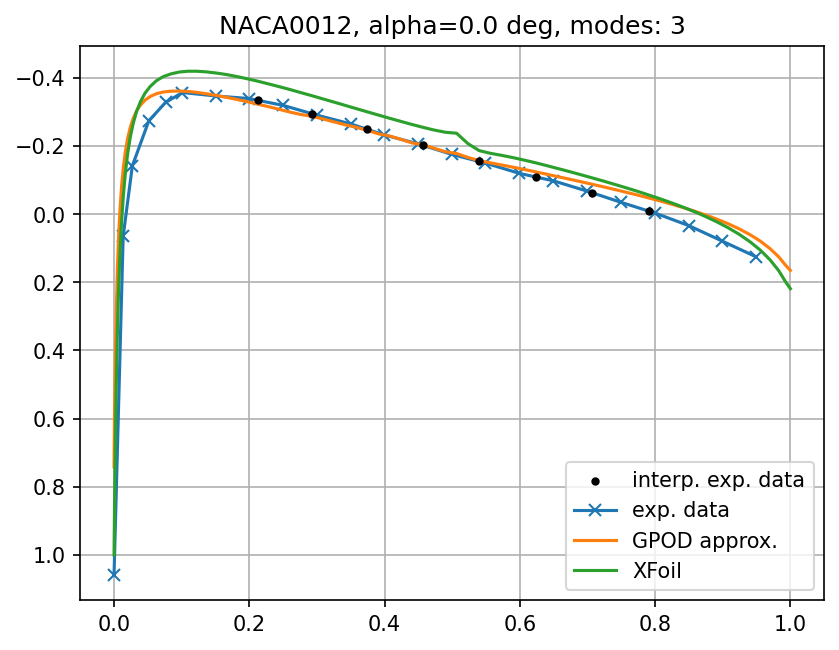

In [307]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(xsel, cpsel, label="interp. exp. data", marker='.', c='k', zorder=8)
ax.plot(df_exp.x, df_exp.Cp, label="exp. data", marker='x')

ax.plot(x_xfoil, cp_gpod, label="GPOD approx.")
ax.plot(x_xfoil, df_lst[2][df_lst[2].region=="suction"].Cp, label="XFoil")

ax.legend()
ax.grid()
ax.invert_yaxis()
ax.set_title(f"NACA0012, alpha=0.0 deg, modes: {modes.shape[1]}")


In [292]:
# compute modes
modes = gappy_POD_basis(cp_data, 6)

In [293]:
# Interpolated experimental data s.t. 
xsel = x_xfoil.loc[x_xfoil[np.logical_and(x_xfoil > 0.2, x_xfoil < 0.8)][::5].index]
cpsel = np.interp(xsel, df_exp.x, df_exp.Cp)

In [294]:
exp_mask = np.zeros((len(modes), 1))
idx_exp = [np.argwhere(x_xfoil == x)[0][0] for x in xsel]
exp_mask[idx_exp, 0] = 1.0
exp_data = np.copy(exp_mask)
exp_data[idx_exp, 0] = cpsel

In [295]:
cp_gpod = reconstruct_data(exp_data, modes, exp_mask)

Text(0.5, 1.0, 'NACA0012, alpha=0.0 deg, modes: 6')

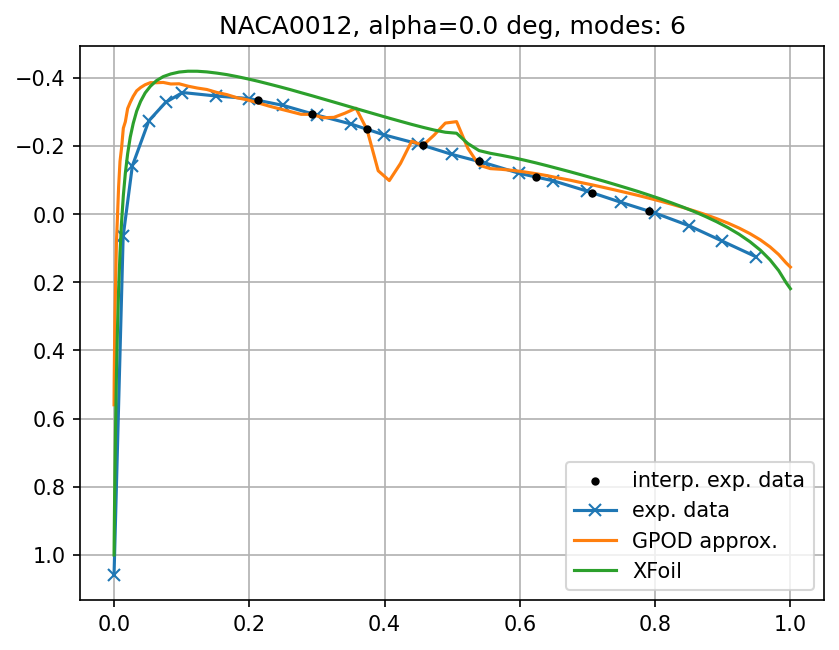

In [301]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(xsel, cpsel, label="interp. exp. data", marker='.', c='k', zorder=8)
ax.plot(df_exp.x, df_exp.Cp, label="exp. data", marker='x')

ax.plot(x_xfoil, cp_gpod, label="GPOD approx.")
ax.plot(x_xfoil, df_lst[2][df_lst[2].region=="suction"].Cp, label="XFoil")

ax.legend()
ax.grid()
ax.invert_yaxis()
ax.set_title(f"NACA0012, alpha=0.0 deg, modes: {modes.shape[1]}")


In [328]:
# compute modes
modes = gappy_POD_basis(cp_data, 12)

(80, 6)


In [319]:
# Interpolated experimental data s.t. 
xsel = x_xfoil.loc[x_xfoil[np.logical_and(x_xfoil > 0.2, x_xfoil < 0.8)][::5].index]
cpsel = np.interp(xsel, df_exp.x, df_exp.Cp)

In [320]:
exp_mask = np.zeros((len(modes), 1))
idx_exp = [np.argwhere(x_xfoil == x)[0][0] for x in xsel]
exp_mask[idx_exp, 0] = 1.0
exp_data = np.copy(exp_mask)
exp_data[idx_exp, 0] = cpsel

In [321]:
cp_gpod = reconstruct_data(exp_data, modes, exp_mask)

Text(0.5, 1.0, 'NACA0012, alpha=0.0 deg, modes: 6')

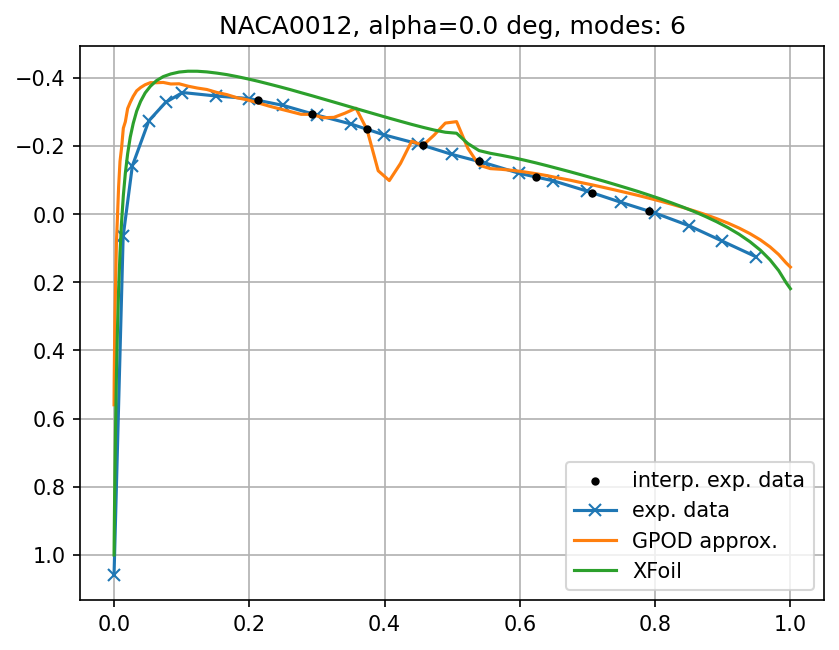

In [322]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(xsel, cpsel, label="interp. exp. data", marker='.', c='k', zorder=8)
ax.plot(df_exp.x, df_exp.Cp, label="exp. data", marker='x')

ax.plot(x_xfoil, cp_gpod, label="GPOD approx.")
ax.plot(x_xfoil, df_lst[2][df_lst[2].region=="suction"].Cp, label="XFoil")

ax.legend()
ax.grid()
ax.invert_yaxis()
ax.set_title(f"NACA0012, alpha=0.0 deg, modes: {modes.shape[1]}")
